In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import geopandas as gpd
import seaborn as sns

#Packages
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from scipy import stats
pd.set_option('display.max_columns', None)

CSV TO parquet conversion for faster datafile load speed...

In [2]:
data = pd.read_csv('july_16_flood_data.parquet.gzip',low_memory=False)

FileNotFoundError: [Errno 2] No such file or directory: 'FimaNfipClaims.csv'

In [ ]:
data['elevationCertificateIndicator'] = data['elevationCertificateIndicator'].astype(str)

In [ ]:
data.to_parquet('FimaNfipClaims.parquet.gzip',
              compression='gzip')

# Data Exploration starts here ...

In [3]:
df = pd.read_parquet('C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/july_16_flood_data.parquet.gzip')

In [3]:
df_test = df[df['buildingPropertyValue'].isna()]

In [5]:
df_test.shape[0]

584636

In [7]:
df_test[df_test['elevationDifference'].isna()].shape[0]

425916

In [9]:
df[df['elevationDifference'].isna()].shape[0]/df.shape[0]

0.7283106613080353

In [4]:
df_test[df['elevationDifference'].isna()].shape[0]/df_test.shape[0]

C:\Users\Asus\AppData\Local\Temp\ipykernel_9536\2916207160.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_test[df['elevationDifference'].isna()].shape[0]/df_test.shape[0]


0.7285148365820784

In [3]:
df.head()

,agricultureStructureIndicator,asOfDate,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,houseWorship,locationOfContents,lowestAdjacentGrade,lowestFloorElevation,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,originalConstructionDate,originalNBDate,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim,postFIRMConstructionIndicator,rateMethod,smallBusinessIndicatorBuilding,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss,primaryResidenceIndicator,buildingDamageAmount,buildingDeductibleCode,netBuildingPaymentAmount,buildingPropertyValue,causeOfDamage,condominiumCoverageTypeCode,contentsDamageAmount,contentsDeductibleCode,netContentsPaymentAmount,contentsPropertyValue,disasterAssistanceCoverageRequired,eventDesignationNumber,ficoNumber,floodCharacteristicsIndicator,floodWaterDuration,floodproofedIndicator,floodEvent,iccCoverage,netIccPaymentAmount,nfipRatedCommunityNumber,nfipCommunityNumberCurrent,nfipCommunityName,nonPaymentReasonContents,nonPaymentReasonBuilding,numberOfUnits,buildingReplacementCost,contentsReplacementCost,replacementCostBasis,stateOwnedIndicator,waterDepth,floodZoneCurrent,buildingDescriptionCode,rentalPropertyIndicator,state,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id
0,0,2020-01-22T16:55:53.194Z,NaN,1,8.0,1998-02-07T00:00:00.000Z,0,nan,NaN,NaN,X,0,NaN,NaN,NaN,4.0,0,10.0,1.0,1963-01-01T00:00:00.000Z,1997-01-11T00:00:00.000Z,NaN,NaN,NaN,0,7,0,200000.0,50000.0,1998,0,382.0,0,0.00,937.0,1,N,NaN,0,0.0,NaN,0.0,None,612.0,NaN,0.0,0,Pineapple Express - Southern,15000.0,0.0,60294.0,None,"OCEANSIDE, CITY OF",97.0,1.0,1.0,937.0,NaN,A,0,0.0,None,NaN,0,CA,Currently Unavailable,92056.0,6073.0,6.073019e+09,6.073019e+10,33.2,-117.3,23dcb0d8-3e61-45bf-899f-b951946ce2ff
1,0,2020-01-22T16:55:53.194Z,NaN,1,8.0,2005-08-29T00:00:00.000Z,0,nan,NaN,NaN,X,0,NaN,NaN,NaN,2.0,0,NaN,1.0,1967-07-01T00:00:00.000Z,1990-07-12T00:00:00.000Z,NaN,NaN,NaN,0,7,0,100000.0,40000.0,2005,1,NaN,0,0.00,NaN,1,N,NaN,0,0.0,NaN,0.0,None,654.0,NaN,0.0,0,Hurricane Katrina,30000.0,0.0,225203.0,None,NEW ORLEANS/ORLEANS PARISH*,6.0,6.0,1.0,NaN,NaN,A,0,0.0,None,NaN,0,LA,Currently Unavailable,70131.0,22071.0,2.207100e+10,2.207100e+11,29.9,-90.0,55783cdd-ccbd-4b19-930b-072def248507
2,0,2020-01-22T16:55:53.194Z,NaN,1,9.0,1998-09-28T00:00:00.000Z,0,nan,NaN,NaN,X,0,NaN,NaN,NaN,1.0,0,10.0,1.0,1972-01-01T00:00:00.000Z,1997-07-24T00:00:00.000Z,8813.21,1720.0,0.0,0,1,0,100000.0,50000.0,1998,1,9313.0,0,8813.21,80000.0,1,N,2220.0,0,1720.0,0.0,0.0,None,133.0,NaN,0.0,0,Hurricane Georges (Panhandle),15000.0,0.0,120274.0,None,SANTA ROSA COUNTY *,NaN,NaN,1.0,100000.0,0.0,A,0,0.0,None,NaN,0,FL,Currently Unavailable,32566.0,12113.0,1.211301e+10,1.211301e+11,30.4,-86.9,bfb5922b-1b21-4882-b1d4-b3825ff53e37
3,0,2019-09-19T13:45:58.425Z,1.0,1,9.0,1994-10-07T00:00:00.000Z,0,nan,NaN,NaN,X,0,NaN,NaN,NaN,2.0,0,10.0,1.0,1960-01-01T00:00:00.000Z,1993-10-01T00:00:00.000Z,2906.00,0.0,0.0,0,7,0,100000.0,25000.0,1994,0,4428.0,0,2906.00,100000.0,1,N,NaN,0,0.0,NaN,0.0,None,NaN,NaN,0.0,0,None,NaN,0.0,450026.0,None,"BEAUFORT, CITY OF",97.0,NaN,1.0,0.0,NaN,A,0,0.0,None,NaN,0,SC,Currently Unavailable,29902.0,45013.0,4.501300e+10,4.501300e+11,32.4,-80.7,c1cf6e00-1e6d-4493-93fc-eb430ef15495
4,0,2019-09-19T13:45:58.425Z,NaN,1,8.0,1996-03-11T00:00:00.000Z,0,nan,NaN,NaN,X,0,NaN,NaN,NaN,1.0,0,NaN,1.0,1988-01-01T00:00:00.000Z,1996-01-11T00:00:00.000Z,3875.53,1545.0,0.0,1,7,0,100000.0,25000.0,1996,1,5252.0,0,3875.53,100000.0,1,N,3115.0,0,1545.0,0.0,0.0,None,NaN,NaN,0.0,0,None,NaN,0.0,125092.0,None,BREVARD COUNTY *,NaN,NaN,1.0,0.0,0.0,A,0,0.0,None,1.0,0,FL,Currently Unavailable,32940.0,12009.0,1.200906e+10,1.200906e+11,28.3,-80.7,cad8334c-13f2-4837-bdcf-e09591197ff7


In [4]:
df = df[(df['buildingPropertyValue'] >= 1000) & (df['buildingPropertyValue'] < 10000000)]

df = df[~df['waterDepth'].isna()]

In [5]:
df['relativeDamage'] = df['buildingDamageAmount']/df['buildingPropertyValue']

df['relativeDamage'].replace([np.inf, -np.inf], np.nan, inplace=True)

df = df[df['relativeDamage'] <= 1]

In [6]:
df['dateOfLoss'] = pd.to_datetime(df['dateOfLoss'])

In [7]:
min_date = df['dateOfLoss'].min()
max_date = df['dateOfLoss'].max()
buckets = pd.date_range(start=min_date, end=max_date, freq='7D')
df['dateOfLoss_bucket'] = pd.cut(df['dateOfLoss'], bins=buckets, labels=buckets[:-1])

In [8]:
df = df[~df['dateOfLoss_bucket'].isna()]

df = df[~df['censusBlockGroupFips'].isna()]

In [9]:
df.shape[0]

1722961

In [10]:
def calculate_mean_relativeDamage(group):
    mean_value = group['relativeDamage'].mean()
    median_value = group['relativeDamage'].median()
    std_value = group['relativeDamage'].std()
    percentile_25 = group['relativeDamage'].quantile(0.25)
    percentile_75 = group['relativeDamage'].quantile(0.75)
    
    
    group['censusBlockGroupFips'] = group['censusBlockGroupFips'].values[0]
    group['dateOfLoss_bucket'] = group['dateOfLoss_bucket'].values[0]
    group['mean_relativeDamage'] = mean_value
    group['median_relativeDamage'] = median_value
    group['std_relativeDamage'] = std_value
    group['percentile_25_relativeDamage'] = percentile_25
    group['percentile_75_relativeDamage'] = percentile_75
    
    return group[['censusBlockGroupFips', 'dateOfLoss_bucket', 'mean_relativeDamage', 'median_relativeDamage', 'std_relativeDamage', 'percentile_25_relativeDamage', 'percentile_75_relativeDamage']]

def calculate_median_waterDepth(group):
    median_value = group['waterDepth'].median()
    mean_value = group['waterDepth'].mean()
    std_value = group['waterDepth'].std()
    percentile_25 = group['waterDepth'].quantile(0.25, interpolation='lower')
    percentile_75 = group['waterDepth'].quantile(0.75, interpolation='lower')
    percentile_90 = group['waterDepth'].quantile(0.90, interpolation='lower')
    
    group['censusBlockGroupFips'] = group['censusBlockGroupFips'].values[0]
    group['dateOfLoss_bucket'] = group['dateOfLoss_bucket'].values[0]
    group['median_waterDepth'] = median_value
    group['mean_waterDepth'] = mean_value
    group['std_waterDepth'] = std_value
    group['percentile_25_waterDepth'] = percentile_25
    group['percentile_75_waterDepth'] = percentile_75
    group['percentile_90_waterDepth'] = percentile_90
    
    # Total number of observations in the group
    total_count = group.shape[0]  
    
    # Number of observations with waterDepth <= 1
    count_less_than_or_equal_to_1 = group[group['waterDepth'] <= 1].shape[0]  
    
    # Proportion of waterDepth <= 1
    proportion_waterDepth_leq_1 = count_less_than_or_equal_to_1 / total_count  

    group['proportion_waterDepth_leq_1'] = proportion_waterDepth_leq_1

    return group[['censusBlockGroupFips', 'dateOfLoss_bucket', 'median_waterDepth', 
                  'mean_waterDepth', 'std_waterDepth', 'percentile_25_waterDepth', 
                  'percentile_75_waterDepth', 'percentile_90_waterDepth', 'proportion_waterDepth_leq_1']]


grouped_df_mean = df.groupby(['censusBlockGroupFips', 'dateOfLoss_bucket'], group_keys=False).apply(calculate_mean_relativeDamage)
grouped_df_median = df.groupby(['censusBlockGroupFips', 'dateOfLoss_bucket'], group_keys=False).apply(calculate_median_waterDepth)


In [11]:
grouped_df_median

,censusBlockGroupFips,dateOfLoss_bucket,median_waterDepth,mean_waterDepth,std_waterDepth,percentile_25_waterDepth,percentile_75_waterDepth
2,1.211301e+11,1998-09-27 00:00:00+00:00,0.0,1.000000,2.000000,0.00,0.75
3,4.501300e+11,1994-10-02 00:00:00+00:00,0.0,0.000000,NaN,0.00,0.00
4,1.200906e+11,1996-03-10 00:00:00+00:00,0.0,0.000000,NaN,0.00,0.00
5,5.181004e+11,1998-02-01 00:00:00+00:00,0.0,1.500000,4.274661,0.00,1.00
8,1.208797e+11,1998-09-27 00:00:00+00:00,0.5,0.500000,0.707107,0.25,0.75
...,...,...,...,...,...,...,...
2583943,1.207106e+11,2022-09-25 00:00:00+00:00,7.0,7.904459,14.885367,0.00,8.00
2583944,1.207106e+11,2022-09-25 00:00:00+00:00,7.0,7.904459,14.885367,0.00,8.00
2584001,6.087110e+10,2023-01-08 00:00:00+00:00,0.0,0.000000,0.000000,0.00,0.00
2584039,4.504392e+11,2022-09-25 00:00:00+00:00,1.0,4.170000,19.724904,0.00,2.00


In [12]:
grouped_df_median[grouped_df_median['median_waterDepth']==0.5]

,censusBlockGroupFips,dateOfLoss_bucket,median_waterDepth,mean_waterDepth,std_waterDepth,percentile_25_waterDepth,percentile_75_waterDepth
8,1.208797e+11,1998-09-27 00:00:00+00:00,0.5,0.500000,0.707107,0.25,0.75
21,4.505105e+11,1999-06-13 00:00:00+00:00,0.5,0.500000,0.707107,0.25,0.75
65,4.835500e+11,2002-06-30 00:00:00+00:00,0.5,0.500000,0.707107,0.25,0.75
238,1.211301e+11,1995-10-01 00:00:00+00:00,0.5,3.916667,9.049946,0.00,3.50
307,1.208600e+11,1992-08-23 00:00:00+00:00,0.5,2.727273,7.666761,0.00,1.75
...,...,...,...,...,...,...,...
2583309,3.605941e+11,2022-12-18 00:00:00+00:00,0.5,4.333333,20.258475,0.00,1.00
2583337,6.069000e+10,2023-03-05 00:00:00+00:00,0.5,0.500000,0.707107,0.25,0.75
2583338,6.069000e+10,2023-03-05 00:00:00+00:00,0.5,0.500000,0.707107,0.25,0.75
2583357,6.087123e+10,2023-03-05 00:00:00+00:00,0.5,0.500000,0.707107,0.25,0.75


In [47]:
# Create a dictionary from the smaller dataframe
mapping_dict = grouped_df_median.set_index(['censusBlockGroupFips', 'dateOfLoss_bucket']).to_dict()

# Map the values from the dictionary to the larger dataframe
df['median_waterDepth'] = df.set_index(['censusBlockGroupFips', 'dateOfLoss_bucket']).index.map(mapping_dict['median_waterDepth'])


In [48]:
# Create a dictionary from the smaller dataframe
mapping_dict = grouped_df_mean.set_index(['censusBlockGroupFips', 'dateOfLoss_bucket']).to_dict()

# Map the values from the dictionary to the larger dataframe
df['mean_relativeDamage'] = df.set_index(['censusBlockGroupFips', 'dateOfLoss_bucket']).index.map(mapping_dict['mean_relativeDamage'])


In [49]:
df.head()

,agricultureStructureIndicator,asOfDate,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,houseWorship,locationOfContents,lowestAdjacentGrade,lowestFloorElevation,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,originalConstructionDate,originalNBDate,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim,postFIRMConstructionIndicator,rateMethod,smallBusinessIndicatorBuilding,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss,primaryResidenceIndicator,buildingDamageAmount,buildingDeductibleCode,netBuildingPaymentAmount,buildingPropertyValue,causeOfDamage,condominiumCoverageTypeCode,contentsDamageAmount,contentsDeductibleCode,netContentsPaymentAmount,contentsPropertyValue,disasterAssistanceCoverageRequired,eventDesignationNumber,ficoNumber,floodCharacteristicsIndicator,floodWaterDuration,floodproofedIndicator,floodEvent,iccCoverage,netIccPaymentAmount,nfipRatedCommunityNumber,nfipCommunityNumberCurrent,nfipCommunityName,nonPaymentReasonContents,nonPaymentReasonBuilding,numberOfUnits,buildingReplacementCost,contentsReplacementCost,replacementCostBasis,stateOwnedIndicator,waterDepth,floodZoneCurrent,buildingDescriptionCode,rentalPropertyIndicator,state,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id,relativeDamage,dateOfLoss_bucket,median_waterDepth,mean_relativeDamage
2,0,2020-01-22T16:55:53.194Z,NaN,1,9.0,1998-09-28 00:00:00+00:00,0,nan,NaN,NaN,X,0,NaN,NaN,NaN,1.0,0,10.0,1.0,1972-01-01T00:00:00.000Z,1997-07-24T00:00:00.000Z,8813.21,1720.0,0.0,0,1,0,100000.0,50000.0,1998,1,9313.0,0,8813.21,80000.0,1,N,2220.0,0,1720.0,0.0,0.0,None,133.0,NaN,0.0,0,Hurricane Georges (Panhandle),15000.0,0.0,120274.0,None,SANTA ROSA COUNTY *,NaN,NaN,1.0,100000.0,0.0,A,0,0.0,None,NaN,0,FL,Currently Unavailable,32566.0,12113.0,1.211301e+10,1.211301e+11,30.4,-86.9,bfb5922b-1b21-4882-b1d4-b3825ff53e37,0.116413,1998-09-27 00:00:00+00:00,0.0,0.032149
3,0,2019-09-19T13:45:58.425Z,1.0,1,9.0,1994-10-07 00:00:00+00:00,0,nan,NaN,NaN,X,0,NaN,NaN,NaN,2.0,0,10.0,1.0,1960-01-01T00:00:00.000Z,1993-10-01T00:00:00.000Z,2906.00,0.0,0.0,0,7,0,100000.0,25000.0,1994,0,4428.0,0,2906.00,100000.0,1,N,NaN,0,0.0,NaN,0.0,None,NaN,NaN,0.0,0,None,NaN,0.0,450026.0,None,"BEAUFORT, CITY OF",97.0,NaN,1.0,0.0,NaN,A,0,0.0,None,NaN,0,SC,Currently Unavailable,29902.0,45013.0,4.501300e+10,4.501300e+11,32.4,-80.7,c1cf6e00-1e6d-4493-93fc-eb430ef15495,0.044280,1994-10-02 00:00:00+00:00,0.0,0.044280
4,0,2019-09-19T13:45:58.425Z,NaN,1,8.0,1996-03-11 00:00:00+00:00,0,nan,NaN,NaN,X,0,NaN,NaN,NaN,1.0,0,NaN,1.0,1988-01-01T00:00:00.000Z,1996-01-11T00:00:00.000Z,3875.53,1545.0,0.0,1,7,0,100000.0,25000.0,1996,1,5252.0,0,3875.53,100000.0,1,N,3115.0,0,1545.0,0.0,0.0,None,NaN,NaN,0.0,0,None,NaN,0.0,125092.0,None,BREVARD COUNTY *,NaN,NaN,1.0,0.0,0.0,A,0,0.0,None,1.0,0,FL,Currently Unavailable,32940.0,12009.0,1.200906e+10,1.200906e+11,28.3,-80.7,cad8334c-13f2-4837-bdcf-e09591197ff7,0.052520,1996-03-10 00:00:00+00:00,0.0,0.052520
5,0,2020-01-22T16:55:53.194Z,NaN,1,NaN,1998-02-03 00:00:00+00:00,1,nan,NaN,NaN,AE,0,NaN,NaN,NaN,1.0,0,10.0,1.0,1970-01-01T00:00:00.000Z,1995-12-03T00:00:00.000Z,14985.92,1510.0,0.0,0,1,0,88000.0,12600.0,1998,0,15735.0,9,14985.92,66000.0,1,N,2260.0,9,1510.0,0.0,0.0,None,119.0,NaN,0.0,0,Flooding,15000.0,0.0,515531.0,None,"VIRGINIA BEACH, CITY OF",NaN,NaN,1.0,88000.0,0.0,A,0,0.0,None,NaN,0,VA,Currently Unavailable,23451.0,51810.0,5.181004e+10,5.181004e+11,36.9,-76.0,60206e0f-ca42-40e0-b82c-d1d78c21c826,0.238409,1998-02-01 00:00:00+00:00,0.0,0.065125
8,0,2019-10-19T03:42:08.849Z,NaN,1,8.0,1998-09-28 00:00:00+00:00,0,nan,NaN,NaN,AE,0,4.0,NaN,NaN,2.0,0,10.0,3.0,1973-01-01T00:00:00.000Z,1996-03-14T00:00:00.000Z,2389.00,0.0,0.0,0,1,0,35000.0,35000.0,1998,1,3139.0,9,2389.00,30450.0,1,U,NaN,9,0.0,NaN,0.0,None,133.0

In [52]:
df['diff_relativeDamage'] = df['relativeDamage'] - df['mean_relativeDamage']
df['diff_waterDepth'] = df['waterDepth'] - df['median_waterDepth']

In [53]:
print(df['diff_relativeDamage'].min())
print(df['diff_relativeDamage'].max())
print(df['diff_waterDepth'].min())
print(df['diff_waterDepth'].max())

-0.9355733214356606
0.9532048873084196
-458.5
999.0


In [ ]:
df.to_parquet('C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/new_variable_FimaNfipClaims.parquet.gzip', compression='gzip')

In [54]:
#waterDepth
threshold_diff_waterDepth = 3

filtered_df = df[(df['diff_waterDepth'].abs() > threshold_diff_waterDepth)]

In [62]:
filtered_df.head()

,agricultureStructureIndicator,asOfDate,basementEnclosureCrawlspaceType,policyCount,crsClassificationCode,dateOfLoss,elevatedBuildingIndicator,elevationCertificateIndicator,elevationDifference,baseFloodElevation,ratedFloodZone,houseWorship,locationOfContents,lowestAdjacentGrade,lowestFloorElevation,numberOfFloorsInTheInsuredBuilding,nonProfitIndicator,obstructionType,occupancyType,originalConstructionDate,originalNBDate,amountPaidOnBuildingClaim,amountPaidOnContentsClaim,amountPaidOnIncreasedCostOfComplianceClaim,postFIRMConstructionIndicator,rateMethod,smallBusinessIndicatorBuilding,totalBuildingInsuranceCoverage,totalContentsInsuranceCoverage,yearOfLoss,primaryResidenceIndicator,buildingDamageAmount,buildingDeductibleCode,netBuildingPaymentAmount,buildingPropertyValue,causeOfDamage,condominiumCoverageTypeCode,contentsDamageAmount,contentsDeductibleCode,netContentsPaymentAmount,contentsPropertyValue,disasterAssistanceCoverageRequired,eventDesignationNumber,ficoNumber,floodCharacteristicsIndicator,floodWaterDuration,floodproofedIndicator,floodEvent,iccCoverage,netIccPaymentAmount,nfipRatedCommunityNumber,nfipCommunityNumberCurrent,nfipCommunityName,nonPaymentReasonContents,nonPaymentReasonBuilding,numberOfUnits,buildingReplacementCost,contentsReplacementCost,replacementCostBasis,stateOwnedIndicator,waterDepth,floodZoneCurrent,buildingDescriptionCode,rentalPropertyIndicator,state,reportedCity,reportedZipCode,countyCode,censusTract,censusBlockGroupFips,latitude,longitude,id,relativeDamage,dateOfLoss_bucket,median_waterDepth,mean_relativeDamage,diff_relativeDamage,diff_waterDepth
9,0,2019-09-19T17:00:12.388Z,NaN,1,8.0,1995-03-11 00:00:00+00:00,0,nan,NaN,NaN,AE,0,NaN,NaN,NaN,1.0,0,10.0,1.0,1957-01-01T00:00:00.000Z,1993-11-29T00:00:00.000Z,12737.86,6177.30,0.0,0,1,0,72500.0,35000.0,1995,1,16135.0,9,12737.86,72500.0,1,N,8055.0,9,6177.30,0.0,0.0,None,580.0,NaN,0.0,0,Flooding,NaN,0.0,60195.0,None,MONTEREY COUNTY *,NaN,NaN,1.0,0.0,0.0,A,0,0.0,None,NaN,0,CA,Currently Unavailable,93923.0,6053.0,6.053012e+09,6.053012e+10,36.5,-121.9,f61464a9-46ad-4adb-9aed-4d175bb69569,0.222552,1995-03-05 00:00:00+00:00,10.0,0.511228,-0.288676,-10.0
14,0,2020-01-22T16:55:53.194Z,NaN,1,NaN,2005-08-29 00:00:00+00:00,0,nan,1.0,11.0,AE,0,NaN,NaN,12.0,4.0,0,NaN,1.0,1970-01-01T00:00:00.000Z,2003-06-20T00:00:00.000Z,169400.00,0.00,0.0,0,1,0,169400.0,0.0,2005,1,208743.0,5,169400.00,218196.0,1,N,NaN,0,0.00,NaN,0.0,None,653.0,NaN,0.0,0,Hurricane Katrina,30000.0,0.0,285256.0,None,JACKSON COUNTY*,NaN,NaN,1.0,220400.0,NaN,A,0,5.0,None,NaN,0,MS,Currently Unavailable,39564.0,28059.0,2.805904e+10,2.805904e+11,30.4,-88.8,3958c762-5b05-493f-9351-bb6079d2b9a7,0.956677,2005-08-28 00:00:00+00:00,10.0,0.789600,0.167077,-5.0
37,0,2020-01-22T16:55:53.194Z,NaN,1,8.0,2005-08-29 00:00:00+00:00,0,nan,5.0,13.0,AE,0,NaN,NaN,18.0,2.0,0,10.0,1.0,1926-01-01T00:00:00.000Z,1997-06-16T00:00:00.000Z,250000.00,100000.00,0.0,0,1,0,250000.0,100000.0,2005,1,323518.0,0,250000.00,329500.0,1,N,100500.0,0,100000.00,0.0,0.0,None,653.0,NaN,0.0,0,Hurricane Katrina,30000.0,0.0,285253.0,None,"GULFPORT, CITY OF",NaN,NaN,1.0,330000.0,0.0,A,0,10.0,None,NaN,0,MS,Currently Unavailable,39501.0,28047.0,2.804700e+10,2.804700e+11,30.4,-89.1,15a48215-afe8-4365-8938-bff32f6a8774,0.981845,2005-08-28 00:00:00+00:00,18.0,0.887577,0.094268,-8.0
52,0,2020-01-22T16:55:53.194Z,NaN,1,7.0,2004-09-16 00:00:00+00:00,0,nan,NaN,NaN,X,0,NaN,NaN,NaN,2.0,0,10.0,1.0,1974-01-01T00:00:00.000Z,2000-02-15T00:00:00.000Z,112634.48,38301.23,10240.0,0,1,0,166000.0,50000.0,2004,1,189617.0,3,112634.48,200970.0,4,N,94049.0,0,38301.23,0.0,0.0,None,643.0,NaN,0.0,0,Hurricane Ivan,30000.0,10240.0,120274.0,None,SANTA ROSA COUNTY *,NaN,NaN,1.0,203000.0,0.0,R,0,6.0,None,NaN,0,FL,Currently Unavailable,32563.0,12113.0,1.211301e+10,1.211301e+11,30.4,-87.1,ef067e3d-6d8a-494a-a184-f95e3eac8958,0.943509,2004-09-12 00:00:00+00:00,1.0,0.619809,0.323700,5.0
101,0,2020-01-22T16:55:53.194Z,NaN,1,NaN,2005-08-29 00:00:00+00:00,0,nan,NaN,NaN,X,0,NaN,NaN,NaN,1.0,0

In [64]:
filtered_df.to_parquet('C:/Users/Asus/Box/Flood Damage PredictionProject/Dataset/waterDepth_diff3.parquet.gzip', compression='gzip')

In [ ]:
#relativeDamage

threshold_diff_relativeDamage = 0.2

filtered_df = df[(df['diff_relativeDamage'].abs() > threshold_diff_relativeDamage)]

filtered_ids = filtered_df['id']

In [ ]:
# grouped_df_mean['dateOfLoss_bucket'] = grouped_df_mean['dateOfLoss_bucket'].astype(str)
# df['dateOfLoss_bucket'] = df['dateOfLoss_bucket'].astype(str)

# df = df.merge(grouped_df_mean, on=['censusBlockGroupFips', 'dateOfLoss_bucket'], how='left')

# grouped_df_median['dateOfLoss_bucket'] = grouped_df_median['dateOfLoss_bucket'].astype(str)

# df = df.merge(grouped_df_median, on=['censusBlockGroupFips', 'dateOfLoss_bucket'], how='left')

In [ ]:
# # Determine the unique values of censusBlockGroupFips
# unique_fips = df['censusBlockGroupFips'].unique()

# # Define the chunk size
# chunk_size = 100

# # Initialize an empty DataFrame to store the merged results
# merged_df = pd.DataFrame()

# # Iterate over the unique fips values in chunks
# for i in range(0, len(unique_fips), chunk_size):
#     # Get the current chunk of fips values
#     fips_chunk = unique_fips[i:i+chunk_size]
    
#     # Filter the main DataFrame based on the fips chunk
#     filtered_df = df[df['censusBlockGroupFips'].isin(fips_chunk)]
    
#     # Perform the groupby operation and calculate mean relative damage within each chunk
#     grouped_df_mean = filtered_df.groupby(['censusBlockGroupFips', 'dateOfLoss_bucket'], group_keys=False).apply(calculate_mean_relativeDamage)
    
#     # Convert dateOfLoss_bucket to the same type as in filtered_df
#     grouped_df_mean['dateOfLoss_bucket'] = grouped_df_mean['dateOfLoss_bucket'].astype(filtered_df['dateOfLoss_bucket'].dtype)
    
#     # Perform the groupby operation and calculate median water depth within each chunk
#     grouped_df_median = filtered_df.groupby(['censusBlockGroupFips', 'dateOfLoss_bucket'], group_keys=False).apply(calculate_median_waterDepth)
    
#     # Convert dateOfLoss_bucket to the same type as in filtered_df
#     grouped_df_median['dateOfLoss_bucket'] = grouped_df_median['dateOfLoss_bucket'].astype(filtered_df['dateOfLoss_bucket'].dtype)
    
#     # Merge the mean and median DataFrames with the filtered DataFrame
#     merged_chunk = filtered_df.merge(grouped_df_mean, on=['censusBlockGroupFips', 'dateOfLoss_bucket'], how='left')
#     merged_chunk = merged_chunk.merge(grouped_df_median, on=['censusBlockGroupFips', 'dateOfLoss_bucket'], how='left')
    
#     # Append the merged chunk to the final DataFrame
#     merged_df = pd.concat([merged_df, merged_chunk])
    
#     print('Done')

# # merged_df will contain the merged results in smaller chunks


In [ ]:
# List of variables to include
variables = ['floodEvent', 'buildingDamageAmount', 'waterDepth', 'replacementCostBasis', 'floodWaterDuration', 'ratedFloodZone', 'censusTract',
              'censusBlockGroupFips', 'countyCode', 'reportedZipCode', 'rateMethod', 'causeOfDamage', 'totalBuildingInsuranceCoverage',
              'occupancyType', 'originalConstructionDate', 'originalNBDate', 'dateOfLoss', 'elevatedBuildingIndicator', 'postFIRMConstructionIndicator',
              'smallBusinessIndicatorBuilding', 'yearOfLoss', 'primaryResidenceIndicator', 'floodproofedIndicator', 'stateOwnedIndicator',
              'rentalPropertyIndicator', 'state', 'reportedCity']

# Filter the DataFrame
filtered_df = df[df[variables].notna().all(axis=1)]

In [ ]:
filtered_df.head()

In [ ]:
filtered_df['rentalPropertyIndicator'].value_counts(dropna=False)

In [ ]:
df['state'].value_counts()

In [ ]:
(df['state'].value_counts()/df.shape[0])*100

In [ ]:
df.shape[0] - df_filtered.shape[0]

In [ ]:
threshold = df['buildingPropertyValue'].quantile(0.975)
df_filtered = df[df['buildingPropertyValue'] <= threshold]

# Assuming your DataFrame is called df
building_property_values = df_filtered['buildingPropertyValue']

plt.figure(figsize=(12, 8))
# Plot histogram
plt.hist(building_property_values, bins=100)  # Adjust the number of bins as needed
plt.xlabel('Building Property Value')
plt.ylabel('Frequency')
plt.title('Histogram of Building Property Values')
plt.show()

In [ ]:
df_temp = df[df['buildingPropertyValue'].isna()]

df_temp.shape[0]

In [ ]:
(df_temp['yearOfLoss'].value_counts()/df['yearOfLoss'].value_counts())*100

In [ ]:
(df_temp['state'].value_counts()/df['state'].value_counts())*100

In [ ]:
df['originalConstructionDate'] = pd.to_datetime(df['originalConstructionDate'], errors='coerce')
df['originalConstructionDate_year'] = df['originalConstructionDate'].dt.year

In [ ]:
df_filtered = df['originalConstructionDate_year'].value_counts().reset_index()

plt.figure(figsize=(12, 8))

plt.bar(df_filtered['index'], df_filtered['originalConstructionDate_year'])
plt.xlabel('Original Building Construction Year')
plt.ylabel('Frequency')
plt.title('Frequency of Original Building Construction Year')
plt.show()


In [ ]:
df['disasterAssistanceCoverageRequired'].value_counts(dropna=False)

In [ ]:
value_counts = df['disasterAssistanceCoverageRequired'].value_counts(dropna=False)


plt.figure(figsize=(12, 8))
# Plot bar chart
plt.bar(value_counts.index.astype(str), value_counts.values)
plt.xlabel('disasterAssistanceCoverageRequired')
plt.ylabel('Frequency')
plt.title('Frequency of disasterAssistanceCoverageRequired')
plt.show()


In [ ]:
df['rentalPropertyIndicator'].value_counts(dropna=False)

In [ ]:
df['elevationDifference'].value_counts(dropna=False)

In [ ]:
df['ratedFloodZone'].value_counts(dropna=False).head(10)

In [ ]:
value_counts = df['ratedFloodZone'].value_counts(dropna=False)


plt.figure(figsize=(16, 12))
# Plot bar chart
plt.bar(value_counts.index.astype(str), value_counts.values)
plt.xlabel('ratedFloodZone')
plt.ylabel('Frequency')
plt.title('Frequency of ratedFloodZone')

plt.xticks(fontsize=6)
plt.show()


In [ ]:
df['rateMethod'].value_counts(dropna=False)

In [ ]:
value_counts = df['rateMethod'].value_counts(dropna=False)


plt.figure(figsize=(12, 8))
# Plot bar chart
plt.bar(value_counts.index.astype(str), value_counts.values)
plt.xlabel('rateMethod')
plt.ylabel('Frequency')
plt.title('Frequency of rateMethod')

plt.xticks(fontsize=6.5)
plt.show()


In [ ]:
df['lowestAdjacentGrade'].value_counts(dropna=False).head(20)

In [ ]:
df_temp = df[df['buildingPropertyValue']>0]

df_temp['relativeDamage'] = df_temp['buildingDamageAmount']/df_temp['buildingPropertyValue']

In [ ]:
threshold = df_temp['buildingDamageAmount'].quantile(0.90)
df_temp = df_temp[df_temp['buildingPropertyValue'] <= threshold]
df_modified = df_temp[(df_temp['waterDepth'] > -10) & (df_temp['waterDepth'] < 50)]

In [ ]:
# Set the seaborn style
sns.set(style='whitegrid')

# Plotting the figure
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_modified, x='waterDepth', y='buildingDamageAmount', width=0.6, linewidth=1.5, 
            color="lightgray", medianprops={"color": "black"})


# Set labels and title
plt.xlabel('waterDepth', fontsize=12)
plt.ylabel('buildingDamageAmount', fontsize=12)
plt.title('buildingDamageAmount Distribution by Year', fontsize=14)

plt.xticks(fontsize=7)


plt.yticks(fontsize=10)

# Add a horizontal grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust plot spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df = df[df['buildingPropertyValue']>0]

In [ ]:
df.shape[0]

In [ ]:
df = df[df['buildingPropertyValue']>0]

df = df[~df['state'].isin(['AK', 'AS', 'MP', 'HI', 'PR', 'GU', 'UN', 'VI'])]

df = df.drop_duplicates()

In [ ]:
df['asOfDate'] = pd.to_datetime(df['asOfDate'])
df['dateOfLoss'] = pd.to_datetime(df['dateOfLoss'])


df['asOfDate_year'] = df['asOfDate'].dt.year
df['asOfDate_month'] = df['asOfDate'].dt.month
df['asOfDate_day'] = df['asOfDate'].dt.day

df['dateOfLoss_year'] = df['dateOfLoss'].dt.year
df['dateOfLoss_month'] = df['dateOfLoss'].dt.month
df['dateOfLoss_day'] = df['dateOfLoss'].dt.day

#relative damage
df['relativeDamage'] = df['buildingDamageAmount']/df['buildingPropertyValue']

df = df[df['relativeDamage'] < 1]

df = df[(df['waterDepth'] > -300) & (df['waterDepth'] < 600)]

In [ ]:
df.head()

In [ ]:
df.shape[0]

In [ ]:
# Set the seaborn style
sns.set(style='whitegrid')

# Plotting the figure
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='dateOfLoss_year', y='waterDepth', width=0.6, linewidth=1.5, 
            color="lightgray", medianprops={"color": "black"})


# Set labels and title
plt.xlabel('Year', fontsize=12)
plt.ylabel('Water Depth', fontsize=12)
plt.title('Water Depth Distribution by Year', fontsize=14)

plt.xticks(fontsize=7)


plt.yticks(fontsize=10)

# Add a horizontal grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust plot spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Set the seaborn style
sns.set(style='whitegrid')

# Plotting the figure
plt.figure(figsize=(12, 8))
sns.boxplot(data=df, x='dateOfLoss_year', y='relativeDamage', width=0.6, linewidth=1.5, 
            color="lightgray", medianprops={"color": "black"})


# Set labels and title
plt.xlabel('Year', fontsize=12)
plt.ylabel('relativeDamage', fontsize=12)
plt.title('relativeDamage Distribution by Year', fontsize=14)

plt.xticks(fontsize=7)


plt.yticks(fontsize=10)

# Add a horizontal grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust plot spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df_modified = df[(df['waterDepth'] > -10) & (df['waterDepth'] < 50)]

In [ ]:
# Set the seaborn style
sns.set(style='whitegrid')

# Plotting the figure
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_modified, x='waterDepth', y='relativeDamage', width=0.6, linewidth=1.5, 
            color="lightgray", medianprops={"color": "black"})


# Set labels and title
plt.xlabel('waterDepth (ft)', fontsize=12)
plt.ylabel('relativeDamage', fontsize=12)
plt.title('relativeDamage Distribution by waterDepth all years', fontsize=14)

plt.xticks(fontsize=7)


plt.yticks(fontsize=10)

# Add a horizontal grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust plot spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df_modified1 = df_modified[df_modified['dateOfLoss_year'] <= 2014]

In [ ]:
# Set the seaborn style
sns.set(style='whitegrid')

# Plotting the figure
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_modified1, x='waterDepth', y='relativeDamage', width=0.6, linewidth=1.5, 
            color="lightgray", medianprops={"color": "black"})


# Set labels and title
plt.xlabel('waterDepth (ft)', fontsize=12)
plt.ylabel('relativeDamage', fontsize=12)
plt.title('relativeDamage Distribution by waterDepth till 2014', fontsize=14)

plt.xticks(fontsize=7)


plt.yticks(fontsize=10)

# Add a horizontal grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust plot spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
df_modified2 = df_modified[df_modified['dateOfLoss_year'] > 2014]

In [ ]:
# Set the seaborn style
sns.set(style='whitegrid')

# Plotting the figure
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_modified2, x='waterDepth', y='relativeDamage', width=0.6, linewidth=1.5, 
            color="lightgray", medianprops={"color": "black"})


# Set labels and title
plt.xlabel('waterDepth (ft)', fontsize=12)
plt.ylabel('relativeDamage', fontsize=12)
plt.title('relativeDamage Distribution by waterDepth after 2014', fontsize=14)

plt.xticks(fontsize=7)


plt.yticks(fontsize=10)

# Add a horizontal grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust plot spacing
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
#Removing outliers

#buildingPropertyValue <0 doesn't make sense

df = df[df['buildingPropertyValue']>0]

# On August 1st, 1993, the Mississippi River at St. Louis crested at 49.58 feet equivalent to 600 inches, 
# the highest stage ever recorded. Anything above 500 inches doesn't make sense for our analysis. 
# Anomalies are generally bad for modelling

df = df[(df['waterDepth'] > -10) & (df['waterDepth'] < 20)]

# The dataset has data for the pacific islands, Porto Rico as well. I believe should remove alaska, 
# Hawaii, porto rico and the pacific islands from our dataset and look only into mainland US.
# In my opinion, pacific islands, porto rico and alaska should be analysed separately from the mainland as their conditions
# are not similar to the mainland and might cause anomalies.

df = df[~df['state'].isin(['AK', 'AS', 'MP', 'HI', 'PR', 'GU', 'UN', 'VI'])]

df = df.drop_duplicates()

In [ ]:
df.head()

In [ ]:
# Creating new variables

# df['originalConstructionDate'] = pd.to_datetime(df['originalConstructionDate'])
# df['originalNBDate'] = pd.to_datetime(df['originalNBDate'])

# df['originalConstructionDate_year'] = df['originalConstructionDate'].dt.year
# df['originalConstructionDate_month'] = df['originalConstructionDate'].dt.month
# df['originalConstructionDate_day'] = df['originalConstructionDate'].dt.day

# df['originalNBDate_year'] = df['originalNBDate'].dt.year
# df['originalNBDate_month'] = df['originalNBDate'].dt.month
# df['originalNBDate_day'] = df['originalNBDate'].dt.day

df['asOfDate'] = pd.to_datetime(df['asOfDate'])
df['dateOfLoss'] = pd.to_datetime(df['dateOfLoss'])


df['asOfDate_year'] = df['asOfDate'].dt.year
df['asOfDate_month'] = df['asOfDate'].dt.month
df['asOfDate_day'] = df['asOfDate'].dt.day

df['dateOfLoss_year'] = df['dateOfLoss'].dt.year
df['dateOfLoss_month'] = df['dateOfLoss'].dt.month
df['dateOfLoss_day'] = df['dateOfLoss'].dt.day

#relative damage
df['relativeDamage'] = df['buildingDamageAmount']/df['buildingPropertyValue']

In [ ]:
unique_counts = df['waterDepth'].value_counts().sort_index()

In [ ]:
unique_counts

In [ ]:
df.head()

In [ ]:
df_modified = df[(df['waterDepth'] > -10) & (df['waterDepth'] < 20)]

min_depth = min(df_modified.waterDepth)
max_depth = max(df_modified.waterDepth)
num_bins = int(max_depth - min_depth) + 1

plt.hist(df_modified.waterDepth, bins=num_bins, range=(min_depth, max_depth + 1), edgecolor='black')

plt.xlabel('Water Depth (inches)')
plt.ylabel('Frequency')
plt.title('Histogram of Water Depth')

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust x-axis tick labels rotation
plt.xticks(rotation=45)

# Add a tighter layout
plt.tight_layout()

plt.show()

In [ ]:
df_modified = df[df['relativeDamage'] < 1]

df_modified = df_modified[(df_modified['waterDepth'] > -1) & (df_modified['waterDepth'] < 14)]

plt.figure(figsize=(12, 8))
sns.boxplot(x="waterDepth", y="relativeDamage", data=df_modified, color="lightgray", medianprops={"color": "black"})

plt.title('Boxplot of Relative Damage by Water Depth all data')
plt.show()

In [ ]:
df_modified = df[df['dateOfLoss_year'] <= 2014]

df_modified = df_modified[df_modified['relativeDamage'] < 1]

df_modified = df_modified[(df_modified['waterDepth'] > -1) & (df_modified['waterDepth'] < 14)]

plt.figure(figsize=(12, 8))
sns.boxplot(x="waterDepth", y="relativeDamage", data=df_modified, color="lightgray", medianprops={"color": "black"})

plt.title('Boxplot of Relative Damage by Water Depth till 2014')
plt.show()

In [ ]:
df_modified = df[df['dateOfLoss_year'] > 2014]

df_modified = df_modified[df_modified['relativeDamage'] < 1]

df_modified = df_modified[(df_modified['waterDepth'] > -1) & (df_modified['waterDepth'] < 14)]

plt.figure(figsize=(12, 8))
sns.boxplot(x="waterDepth", y="relativeDamage", data=df_modified, color="lightgray", medianprops={"color": "black"})

plt.title('Boxplot of Relative Damage by Water Depth after 2014')
plt.show()

In [ ]:
df.head()

In [ ]:
average_damage_by_state = df[~df['state'].isin(['AK', 'AS', 'MP', 'HI', 'PR', 'GU', 'UN', 'VI'])].groupby('state')['relativeDamage'].mean()


# Sort the average damage by state name
average_damage_by_state = average_damage_by_state.sort_index()

# Create a bar plot
plt.figure(figsize=(12, 6))
average_damage_by_state.plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Average Relative Damage')
plt.title('Average Relative Damage by State')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
df_modified = df[df['relativeDamage'] < 1]

df_modified = df_modified[(df_modified['waterDepth'] > -1) & (df_modified['waterDepth'] < 14)]


average_damage_by_state = df_modified[~df_modified['state'].isin(['AK', 'AS', 'MP', 'HI', 'PR', 'GU', 'UN', 'VI'])].groupby('state')['relativeDamage'].mean()


# Sort the average damage by state name
average_damage_by_state = average_damage_by_state.sort_index()

# Read the shapefile
shapefile_path = 'cb_2018_us_state_500k.shp'  # Replace with the path to your shapefile
map_df = gpd.read_file(shapefile_path)

# Merge the shapefile with the average damage data
merged = map_df.set_index('STUSPS').join(average_damage_by_state)

# Create a choropleth map
fig, ax = plt.subplots(figsize=(12, 8))
merged.plot(column='relativeDamage', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Average Relative Damage by State')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
df_modified = df[df['relativeDamage'] < 1]

df_modified = df_modified[df_modified['dateOfLoss_year'] <= 2014]

df_modified = df_modified[(df_modified['waterDepth'] > -1) & (df_modified['waterDepth'] < 14)]


average_damage_by_state = df_modified[~df_modified['state'].isin(['AK', 'AS', 'MP', 'HI', 'PR', 'GU', 'UN', 'VI'])].groupby('state')['relativeDamage'].mean()


# Sort the average damage by state name
average_damage_by_state = average_damage_by_state.sort_index()

# Read the shapefile
shapefile_path = 'cb_2018_us_state_500k.shp'  # Replace with the path to your shapefile
map_df = gpd.read_file(shapefile_path)

# Merge the shapefile with the average damage data
merged = map_df.set_index('STUSPS').join(average_damage_by_state)

# Create a choropleth map
fig, ax = plt.subplots(figsize=(12, 8))
merged.plot(column='relativeDamage', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Average Relative Damage by State till 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
df_modified = df[df['relativeDamage'] < 1]

df_modified = df_modified[df_modified['dateOfLoss_year'] > 2014]

df_modified = df_modified[(df_modified['waterDepth'] > -1) & (df_modified['waterDepth'] < 14)]


average_damage_by_state = df_modified[~df_modified['state'].isin(['AK', 'AS', 'MP', 'HI', 'PR', 'GU', 'UN', 'VI'])].groupby('state')['relativeDamage'].mean()


# Sort the average damage by state name
average_damage_by_state = average_damage_by_state.sort_index()

# Read the shapefile
shapefile_path = 'cb_2018_us_state_500k.shp'  # Replace with the path to your shapefile
map_df = gpd.read_file(shapefile_path)

# Merge the shapefile with the average damage data
merged = map_df.set_index('STUSPS').join(average_damage_by_state)

# Create a choropleth map
fig, ax = plt.subplots(figsize=(12, 8))
merged.plot(column='relativeDamage', cmap='YlOrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)
plt.title('Average Relative Damage by State after 2014')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


In [ ]:
shapefile_path = 'cb_2018_us_state_500k.shp' 
map_df = gpd.read_file(shapefile_path)

In [ ]:
map_df.head()

In [ ]:
df.head()

In [ ]:
map_df.head()

In [ ]:
from shapely.geometry import Point
shapefile_path_new = 'bx729wr3020.shp'
map_df = gpd.read_file(shapefile_path_new)

df['city_name'] = ''

# Iterate over the rows in the other dataset
for index, row in df.iterrows():
    latitude = row['latitude']
    longitude = row['longitude']
    
    # Find the city that contains the given latitude and longitude
    city = map_df[map_df['geometry'].contains(Point(longitude, latitude))]['name'].values
    
    if len(city) > 0:
        df.at[index, 'city_name'] = city[0]

In [ ]:
df.head()

In [21]:
df = df[~df['waterDepth'].isna()]

In [22]:
df.shape[0]

2366780

In [23]:
df['waterDepth'].max()

999.0

In [24]:
df['waterDepth'].min()

-999.0

In [26]:
df_new = df[~(df['waterDepth'] == 0)]

In [30]:
df_new = df_new[(df_new['waterDepth'] > -20) & (df_new['waterDepth'] < 50)]

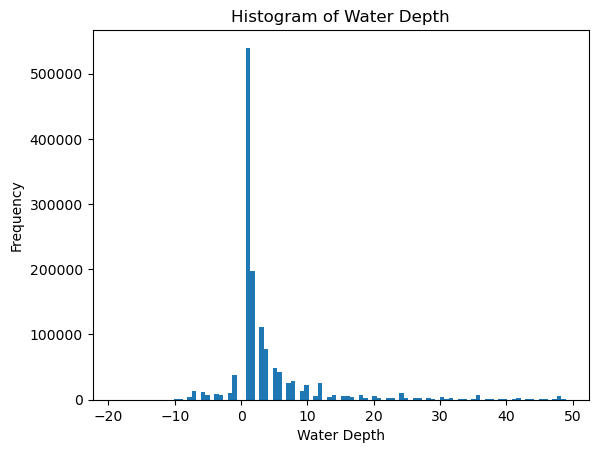

In [31]:
plt.hist(df_new['waterDepth'], bins=100)  # You can adjust the number of bins as per your preference
plt.xlabel('Water Depth')
plt.ylabel('Frequency')
plt.title('Histogram of Water Depth')
plt.show()